In [1]:
mp_pdf = False
import django, sys, os
if mp_pdf:
    extension = "pdf"
    import matplotlib
    matplotlib.use('pgf')
    pgf_with_latex = {
        "text.usetex": True,            # use LaTeX to write all text
        "pgf.rcfonts": False,           # Ignore Matplotlibrc
        "text.latex.unicode": True,
        "pgf.preamble": [
            #r"\usepackage[utf8x]{inputenc}",
            r"\usepackage{xcolor}"
        ],
        "pgf.texsystem" : "xelatex",
        "figure.figsize": [12,7]
    }
    matplotlib.rcParams.update(pgf_with_latex)
else:
    extension = "png"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle
%matplotlib notebook

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from scipy.sparse import coo_matrix, find
from sklearn.manifold import TSNE

from scoping.models import *
from tmv_app.models import *
import tmv_app.utils.plotting as tplots
from time import time
from matplotlib import patches

run_id = 1013
s = 0
#s = 50000
p = 20

run_id=665
run_id=1056
run_id=1103
run_id = 1429
run_id = 1771
p = 100
#p = 50
p = 200

stat = RunStats.objects.get(run_id=run_id)
q = stat.query
qid = q.id


In [2]:
mdf = pd.read_csv('../tables/newness_representation.csv')
mdf.head()

ipcc_coverage  ipcc_score  ipcc_share  primary_wg       score     share  \
0       0.124080   23.350617    0.007434           2  359.276672  0.008071   
1       0.044843    5.862199    0.001866           3  296.049958  0.006651   
2       0.139370   41.974170    0.013363           2  588.748127  0.013226   
3       0.162331   11.758774    0.003744           2  149.953744  0.003369   
4       0.065671   10.143984    0.003230           1  262.705326  0.005902   

                              title  deviation    abs_md  representation  \
0         {forest, stand, tropical}  -0.000637  0.000637        0.921081   
1  {power, generation, electricity}  -0.004784  0.004784        0.280623   
2    {ecosystem, net, productivity}   0.000137  0.000137        1.010371   
3          {coral, reef, bleaching}   0.000375  0.000375        1.111304   
4        {delta, isotope, thousand}  -0.002672  0.002672        0.547228   

         ys   year_av      lrep  x_q  y_q  
0  0.434543  4.408163 -0.082208    1    3  
1  0.396767  4.642857 -1.270742    5    0  
2  0.422627  4.510638  0.010318    3    3  
3  0.440267  4.645833  0.105534    5    4  
4  0.490931  4.339286 -0.602891    0    1

In [3]:
def square_distance(x,y): return sum([(xi-yi)**2 for xi, yi in zip(x,y)]) 

In [4]:
m = np.load('../tsne_results/data/run_{}_s_{}_m.npy'.format(run_id,s))
r_ind = np.load('../tsne_results/data/run_{}_s_{}_r_ind.npy'.format(run_id,s))
tsne_results = np.load('../tsne_results/data/run_{}_s_{}_p{}.npy'.format(run_id,s,p))

In [5]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
no_oecd_ids = r_ind

oecd_cats = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    {'wc__oecd': None}
]

oecd_df = pd.DataFrame()
for i,c in enumerate(oecd_cats):
    ds = Doc.objects.filter(query=q,wc__oecd=c['wc__oecd']).values_list('id', flat=True)
    c['docs'] = list(set(ds) & set(r_ind))
    oecd_df = pd.concat([oecd_df,pd.DataFrame({
        "oecd": c['wc__oecd'], "doc": c['docs']
    })])
    c['n_docs'] = len(c['docs'])
    c['name'] = c['wc__oecd']
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_oecd_ids = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]
    
from operator import itemgetter
oecd_cats = sorted(oecd_cats, key=itemgetter('n_docs'), reverse=True)

In [6]:
oecd_df = oecd_df.reset_index(drop=True)
oecd_df.to_csv(f"../tables/oecd_cats_{qid}.csv")

calculating points took 1.471s.
[-20. -15. -10.  -5.   0.   5.  10.  15.  20.]


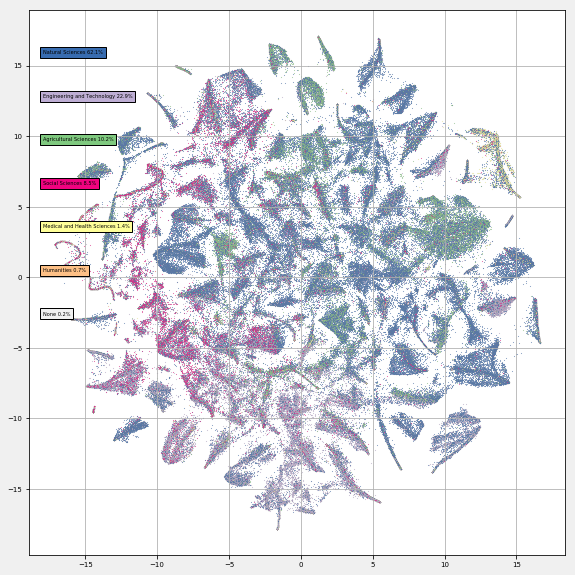

In [7]:
import importlib
importlib.reload(tmv_app.utils.plotting)

plt.close()

fig, ax = plt.subplots( figsize=(8,8))
tplots.plot_tsne(r_ind,tsne_results,oecd_cats,no_oecd_ids,verbose=True,ax=ax)

fig.patch.set_facecolor('#f0f0f0') 

fig.tight_layout()

plt.savefig(
    f'../tsne_results/plots/run_{run_id}_s_{s}_p{p}_oecds.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

sc = tplots.SquareCollection()   
xs = plt.xticks()[0]
ys = plt.yticks()[0]

print(xs)

for i, x1 in enumerate(xs):
    if i==len(xs)-1:
        break
    x2 = xs[i+1]
    for j, y1 in enumerate(ys):
        if j==len(ys)-1:
            break
        y2 = ys[j+1]

        cs = tplots.CoordSquare(x1,x2,y1,y2,r_ind,tsne_results,0)
        cs.get_points()
        sc.add(cs)
    
plt.show()

In [8]:
sum_topics = False

if sum_topics:
    df = None
    for cs in sc.objects:
        if cs.share > 0:
            topics = cs.summarise_topics(run_id)
            if df is None:
                df = topics
            else:
                df = df.append(topics)
    df.to_csv(f"../tables/tsne_topic_index_{run_id}_{p}.csv")

In [9]:
if sum_topics:
    import importlib
    importlib.reload(tmv_app.utils.plotting)

    fig, ax = plt.subplots( figsize=(8,8))

    tplots.plot_tsne(
        r_ind,tsne_results,oecd_cats,no_oecd_ids,
        verbose=True,ax=ax,
        heat_var="av_y",sc=sc,cmapname="RdYlBu"
    )

    if mp_pdf:
        plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_timeheat.pdf'.format(run_id,s,p))
    else:
        plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_timeheat.png'.format(run_id,s,p))

    plt.show()

In [10]:
if sum_topics:
    import importlib
    importlib.reload(tmv_app.utils.plotting)

    fig, ax = plt.subplots( figsize=(8,8))

    tplots.plot_tsne(
        r_ind,tsne_results,oecd_cats,no_oecd_ids,
        verbose=True,ax=ax,
        heat_var="H",sc=sc,cmapname="RdYlBu"
    )

    if mp_pdf:
        plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_H_heat.pdf'.format(run_id,s,p))
    else:
        plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_H_heat.png'.format(run_id,s,p))

    plt.show()

In [11]:
if stat.method=="DT":

    dts = DocDynamicTopic.objects.filter(
        run_id=run_id, score__gt=0.03
    ).values('doc').annotate(
        n = Count('pk')
    )
    
else:
    dts = DocTopic.objects.filter(
        run_id=run_id, score__gt=stat.dt_threshold
    ).values('doc').annotate(
        n = Count('pk')
    )
thickness_cats = []
m = dts.order_by('-n').first()['n']
m = 10
thicknesses = list(range(m+1))

from matplotlib import cm

cmap = cm.get_cmap("YlGnBu")

for t in thicknesses:
    if t==0:
        doc_ids = list(set(r_ind) - set(dts.values_list('doc__id',flat=True)))
    else:
        doc_ids = list(dts.filter(n=t).values_list('doc__id',flat=True))
    thickness_cats.append({
        "name": str(t),
        "docs": doc_ids,
        "n_docs": len(doc_ids),
        "color": cmap(t/m),
        "dis": np.argwhere(np.isin(r_ind,doc_ids))
    })
    
    


calculating points took 1.235s.


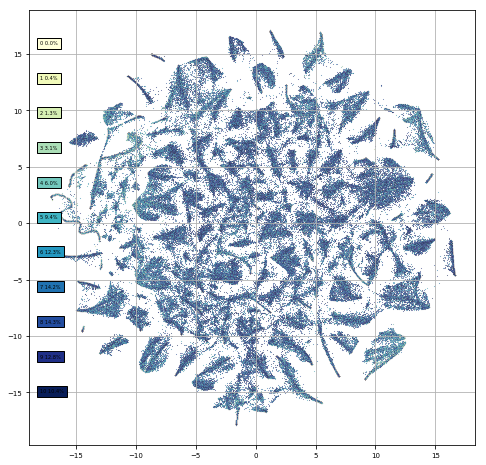

In [12]:
fig, ax = plt.subplots( figsize=(8,8))
tplots.plot_tsne(r_ind,tsne_results,thickness_cats,[],verbose=True,ax=ax)
if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_thickness.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_thickness.png'.format(run_id,s,p))
    
plt.show()


In [13]:

ars = AR.objects.filter(ar__gt=0).order_by('ar')
m = ars.count()

ar_cats = []

for i,ar in enumerate(ars):
    ys = range(ar.start,ar.end+1)
    ydocs = Doc.objects.filter(query=q,PY__in=ys).values_list('pk',flat=True)  
    ar_cats.append({
        "name": ar.name,
        "docs": list(set(ydocs) & set(r_ind)),
        "n_docs": len(ydocs),
        "color": cmap(1-(i+1)/m),
        "dis": np.argwhere(np.isin(r_ind,ydocs))
    })


calculating points took 1.110s.


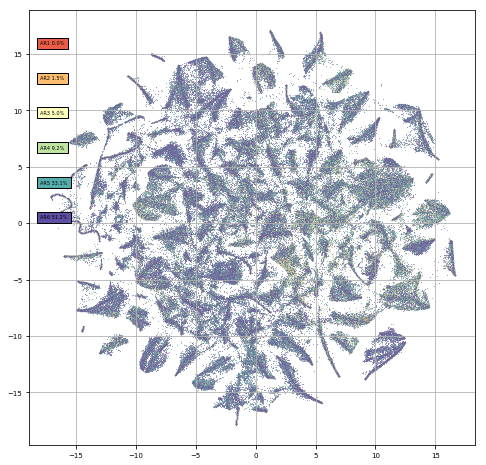

In [14]:
cmap = cm.get_cmap("RdYlBu")

cmaps = [
    #"RdYlBu",
    "Spectral"
]

fig, axs = plt.subplots(len(cmaps), figsize=(8,8*len(cmaps))) 

if len(cmaps)==1:
    axs = [axs]

for a,c in enumerate(cmaps):
    cmap = cm.get_cmap(c)
    ax = axs[a]

    for i, ar in enumerate(ar_cats):
        ar["color"] = cmap(1-(i+1)/m)
        ar["color"] = cmap((i+1)/m)

    tplots.plot_tsne(r_ind,tsne_results,ar_cats,[],verbose=True,ax=ax)
    
if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_ars.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_ars.png'.format(run_id,s,p))

calculating points took 0.268s.
calculating points took 0.834s.


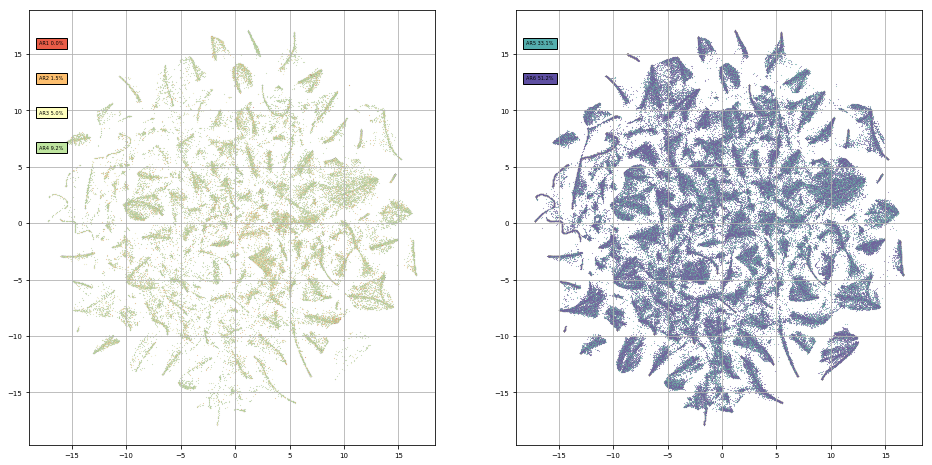

In [15]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
tplots.plot_tsne(r_ind,tsne_results,ar_cats[:4],[],verbose=True,ax=ax[0])
tplots.plot_tsne(r_ind,tsne_results,ar_cats[4:],[],verbose=True,ax=ax[1])
plt.show()

In [16]:
colors=["#66c2a5","#fc8d62","#8da0cb"]

no_wg_ids = r_ind
wgs = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
for i,c in enumerate(wgs):
    docs = Doc.objects.filter(
        query=q,ipccref__wg__wg=c['wg']
    ).values_list('id',flat=True)
    c['docs'] = list(set(docs) & set(r_ind))
    c['color'] = colors[i]
    c['name'] = "WG{}".format(c['wg'])
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_wg_ids = no_wg_ids[np.isin(no_wg_ids,c['docs'],invert=True)]
    


calculating points took 1.192s.


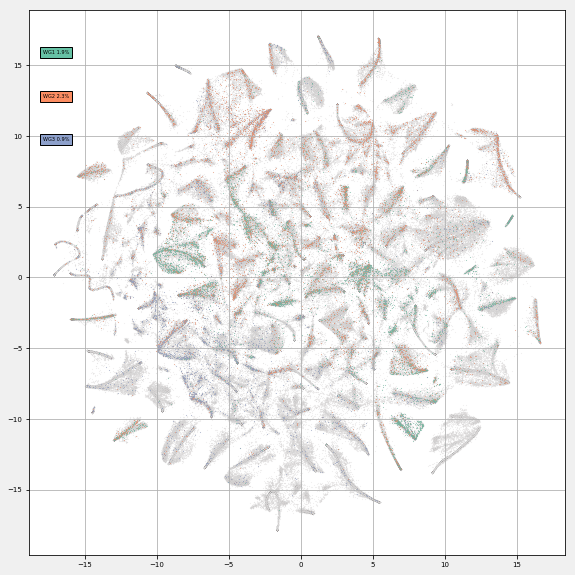

In [17]:
import importlib
importlib.reload(tmv_app.utils.plotting)

plt.close()

fig, ax = plt.subplots(figsize=(8,8))

fig.patch.set_facecolor('#f0f0f0') 

tmv_app.utils.plotting.plot_tsne(r_ind,tsne_results,wgs,no_wg_ids,verbose=True,ax=ax)

fig.patch.set_facecolor('#f0f0f0') 

fig.tight_layout()

plt.savefig(
    f'../tsne_results/plots/run_{run_id}_s_{s}_p{p}_wgs.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)


plt.show()

In [18]:
mdf

ipcc_coverage  ipcc_score  ipcc_share  primary_wg       score     share  \
0         0.124080   23.350617    0.007434           2  359.276672  0.008071   
1         0.044843    5.862199    0.001866           3  296.049958  0.006651   
2         0.139370   41.974170    0.013363           2  588.748127  0.013226   
3         0.162331   11.758774    0.003744           2  149.953744  0.003369   
4         0.065671   10.143984    0.003230           1  262.705326  0.005902   
5         0.282210   37.337015    0.011887           1  197.337780  0.004433   
6         0.077888   15.247855    0.004854           3  434.936538  0.009771   
7         0.103455   11.589915    0.003690           2  235.272122  0.005285   
8         0.105231   18.419785    0.005864           2  362.843129  0.008151   
9         0.054569    4.693357    0.001494           2  249.009040  0.005594   
10        0.126728   22.588853    0.007192           2  334.296021  0.007510   
11        0.046439    7.690942    0.002449           1  314.752467  0.007071   
12        0.103696   17.518614    0.005577           2  358.267682  0.008048   
13        0.153342   18.521397    0.005897           2  268.770343  0.006038   
14        0.064388   23.157479    0.007373           2  668.743314  0.015023   
15        0.108965   14.636562    0.004660           2  318.499860  0.007155   
16        0.106912   36.991348    0.011777           2  776.126405  0.017436   
17        0.115334   42.544068    0.013545           2  670.289132  0.015058   
18        0.143911   27.014417    0.008601           2  423.422252  0.009512   
19        0.149909   49.599066    0.015791           2  622.388016  0.013982   
20        0.038575    6.486784    0.002065           1  403.959784  0.009075   
21        0.017743    1.550776    0.000494           1  243.567673  0.005472   
22        0.212624   41.491295    0.013210           2  403.217450  0.009058   
23        0.112237   22.996212    0.007321           2  472.315665  0.010610   
24        0.135693   32.552611    0.010364           1  415.739374  0.009339   
25        0.046403    5.167948    0.001645           3  277.516540  0.006234   
26        0.088544    6.296632    0.002005           2  168.614961  0.003788   
27        0.344839   44.980636    0.014320           2  312.070762  0.007011   
28        0.091601   12.528764    0.003989           2  277.135127  0.006226   
29        0.162819   34.485598    0.010979           2  436.333392  0.009802   
..             ...         ...         ...         ...         ...       ...   
90        0.113975   26.652159    0.008485           2  480.996391  0.010805   
91        0.088178   13.607915    0.004332           3  324.394104  0.007287   
92        0.052300    7.558098    0.002406           1  244.101256  0.005484   
93        0.150252   39.310948    0.012515           3  503.355989  0.011308   
94        0.274740   53.197864    0.016937           1  365.364546  0.008208   
95        0.132973   27.337048    0.008703           1  413.371709  0.009286   
96        0.088260   13.628743    0.004339           2  303.035785  0.006808   
97        0.114022   21.179622    0.006743           1  301.038914  0.006763   
98        0.060596    4.330002    0.001379           3  164.766847  0.003701   
99        0.152802   33.777206    0.010754           2  396.666629  0.008911   
100       0.289384   55.681704    0.017727           2  376.462408  0.008457   
101       0.075490   14.940218    0.004756           2  378.603797  0.008505   
102       0.069166   10.638713    0.003387           3  308.917472  0.006940   
103       0.154136   38.646261    0.012304           1  486.406129  0.010927   
104       0.191757   30.877103    0.009830           1  315.396351  0.007085   
105       0.211961   45.161653    0.014378           1  368.938187  0.008288   
106       0.048640    6.407688    0.002040           2  244.105669  0.005484   
107       0.120797   15.911761    0.005066           2  288.184528  0.006474   
108  

In [19]:
tops = DynamicTopic.objects.filter(id__in=[
    12156,
    #12179,
    12160, # waste
    12167,
    12187,
    12152,
    12195,
    12150,
    12200,
    12186,
    12157,
    12172,
    12178,
    #12221,
    12202,
    12218
])

tops = DynamicTopic.objects.filter(id__in=[
    12454,
    #12179,
    12475,
    12525,
    12506,
    12492,
    12457,
    12486,
    12462,
    12476,
    12448,
    12468
])

calculating points took 1.062s.


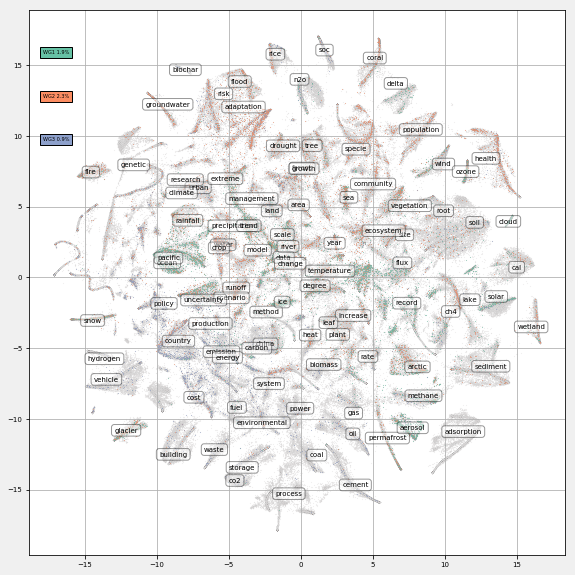

In [20]:
import importlib
importlib.reload(tmv_app.utils.plotting)

tops = Topic.objects.filter(
    run_id=run_id,
    #primary_wg=3,
    #title__icontains="biochar",
    #title__in=mdf[(mdf['representation']<1) & (mdf['year_av']>4.6)]['title']
)

fig, ax = plt.subplots( figsize=(8,8)) 
tplots.plot_tsne(
    r_ind,tsne_results,
    wgs,no_wg_ids,verbose=True,ax=ax,
    topics=tops,
    eps=1.5,
    t_thresh=0.98,
    min_cluster=200,
    words_only=True
)

fig.patch.set_facecolor('#f0f0f0') 

fig.tight_layout()

plt.savefig(
    f'../tsne_results/plots/run_{run_id}_s_{s}_p{p}_all_topic_words_wgs.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)


calculating points took 1.064s.


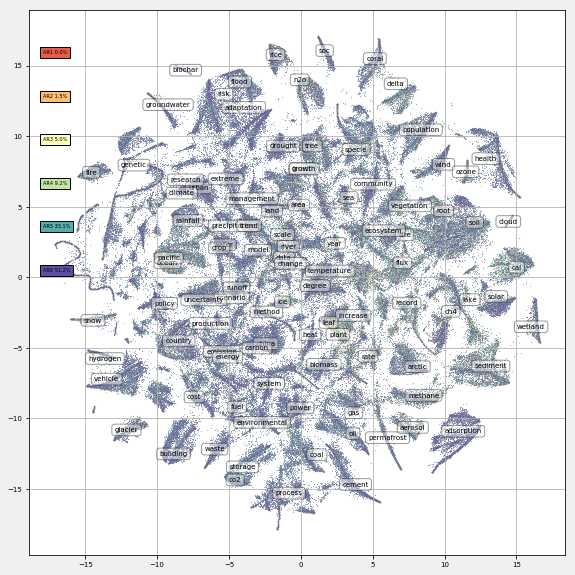

In [21]:
import importlib
importlib.reload(tmv_app.utils.plotting)

tops = Topic.objects.filter(
    run_id=run_id,
    #primary_wg=3,
    #title__icontains="biochar",
    #title__in=mdf[(mdf['representation']<1) & (mdf['year_av']>4.6)]['title']
)

fig, ax = plt.subplots( figsize=(8,8)) 
tplots.plot_tsne(
    r_ind,tsne_results,
    ar_cats,[],verbose=True,ax=ax,
    topics=tops,
    eps=1.5,
    t_thresh=0.98,
    min_cluster=200,
    words_only=True
)

fig.patch.set_facecolor('#f0f0f0') 

fig.tight_layout()

plt.savefig(
    f'../tsne_results/plots/run_{run_id}_s_{s}_p{p}_all_topic_words_ars.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)


calculating points took 1.364s.


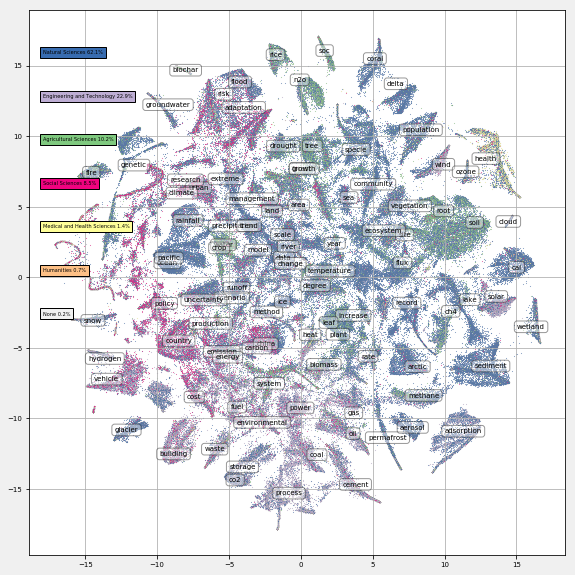

In [22]:
import importlib
importlib.reload(tmv_app.utils.plotting)

tops = Topic.objects.filter(
    run_id=run_id,
    #primary_wg=3,
    #title__icontains="biochar",
    #title__in=mdf[(mdf['representation']<1) & (mdf['year_av']>4.6)]['title']
)

fig, ax = plt.subplots( figsize=(8,8)) 
tplots.plot_tsne(
    r_ind,tsne_results,
    oecd_cats,no_oecd_ids,verbose=True,ax=ax,
    topics=tops,
    eps=1.5,
    t_thresh=0.98,
    min_cluster=200,
    words_only=True
)

fig.patch.set_facecolor('#f0f0f0') 

fig.tight_layout()

plt.savefig(
    f'../tsne_results/plots/run_{run_id}_s_{s}_p{p}_all_topic_words_oecds.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

## Plots with certain labelled topics

<QuerySet [<Topic: {biochar, application, amendment}>, <Topic: {research, social, issue}>, <Topic: {coral, reef, bleaching}>]>


<IPython.core.display.Javascript object>


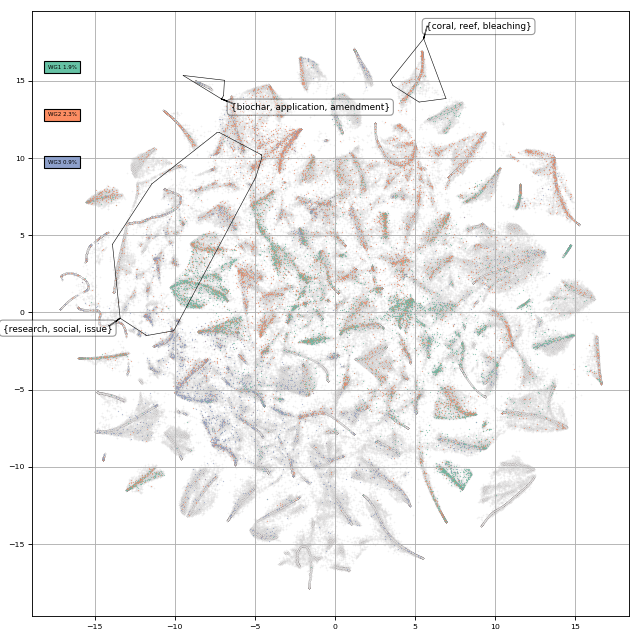

calculating points took 1.148s.


In [115]:
import importlib
importlib.reload(tmv_app.utils.plotting)

tops = Topic.objects.filter(
    run_id=run_id,
    #primary_wg=3,
    title__iregex="biochar|coral|research",
    #title__in=mdf[(mdf['representation']<1) & (mdf['year_av']>4.6)]['title']
)

print(tops)


fig, ax = plt.subplots( figsize=(8,8)) 
tplots.plot_tsne(
    r_ind,tsne_results,
    wgs,no_wg_ids,verbose=True,ax=ax,
    topics=tops,
    eps=1.5,
    t_thresh=0.98,
    min_cluster=200,
    #words_only=True
)

fig.patch.set_facecolor('#f0f0f0') 

fig.tight_layout()

plt.savefig(
    f'../tsne_results/plots/run_{run_id}_s_{s}_p{p}_interesting_topics_wgs.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)


<IPython.core.display.Javascript object>


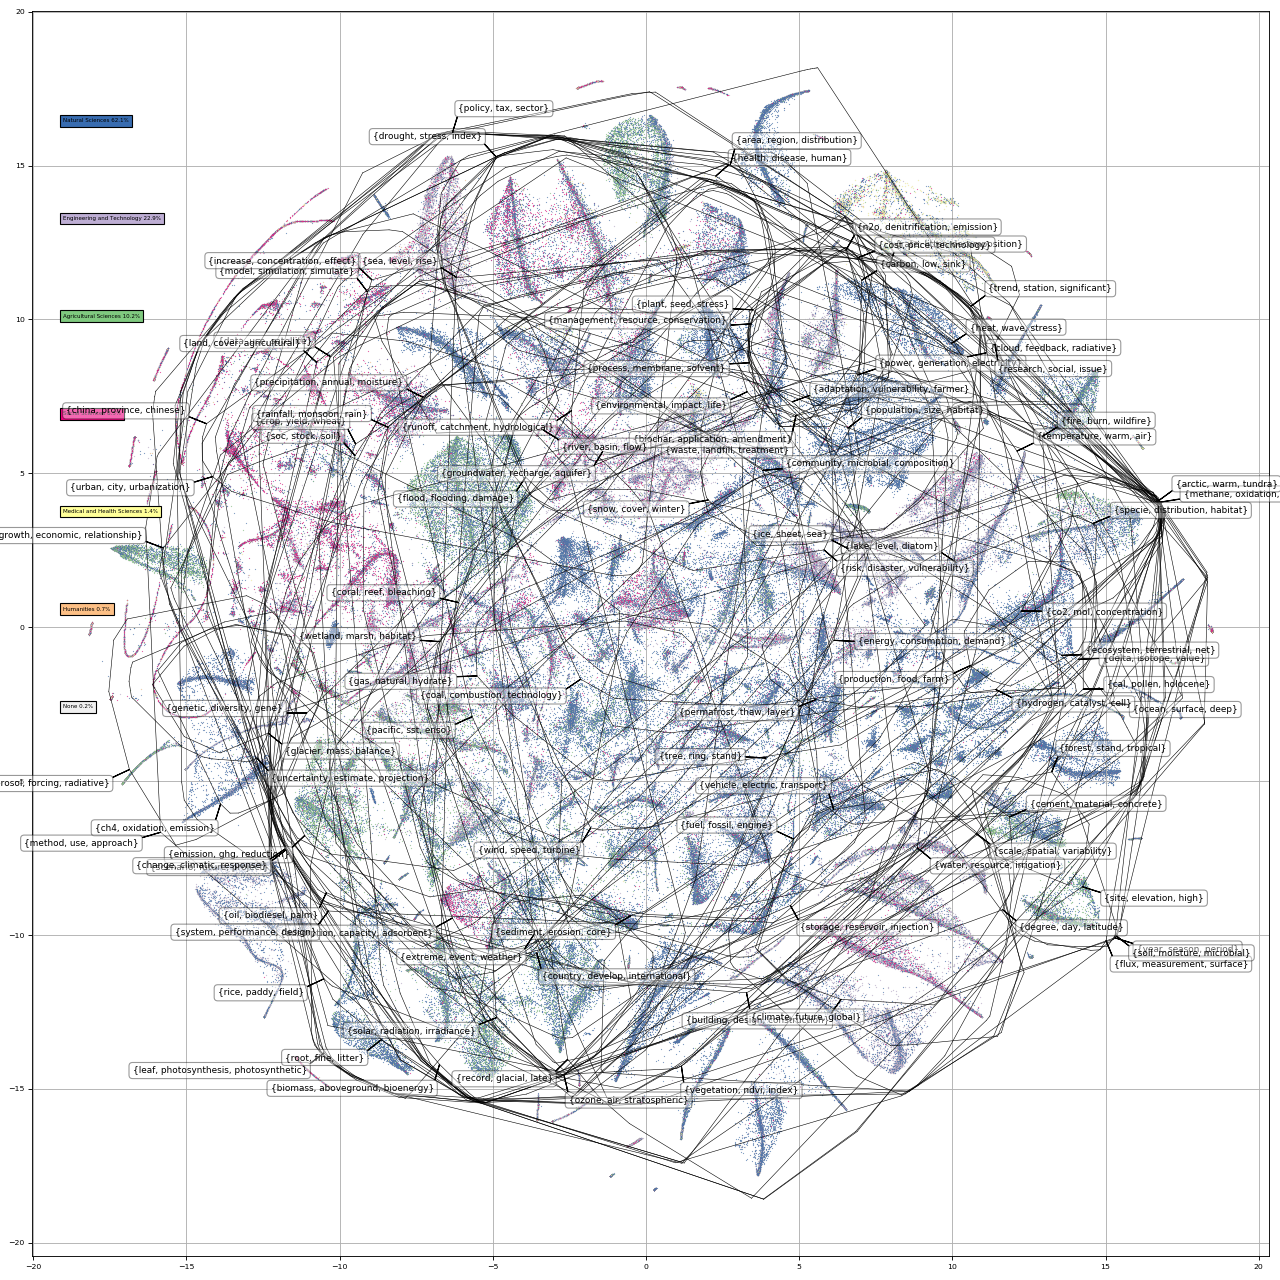

calculating points took 1.411s.


In [74]:
fig, ax = plt.subplots( figsize=(16,16)) 
tplots.plot_tsne(
    r_ind,tsne_results,
    oecd_cats,no_oecd_ids,verbose=True,ax=ax,
    topics=tops
)

fig.patch.set_facecolor('#f0f0f0') 

fig.tight_layout()

plt.savefig(
    f'../tsne_results/plots/run_{run_id}_s_{s}_p{p}_interesting_topics_oecds.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)


calculating points took 1.124s.
calculating points took 1.181s.


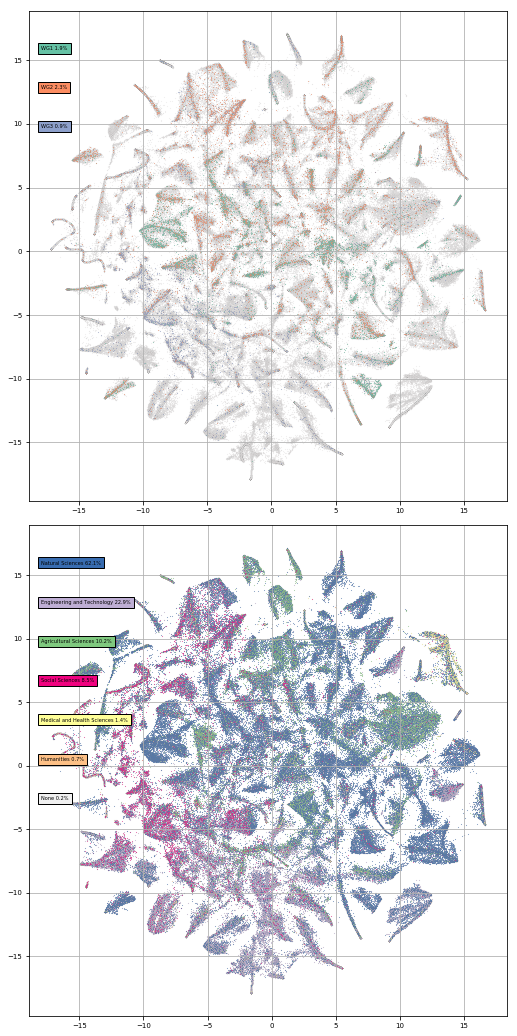

In [24]:
fig, axs = plt.subplots(2,1,figsize=(7.2,14.4))
tmv_app.utils.plotting.plot_tsne(
    r_ind,tsne_results,wgs,
    no_wg_ids,axs[0],verbose=True
)

tmv_app.utils.plotting.plot_tsne(
    r_ind,tsne_results,oecd_cats,
    no_oecd_ids,axs[1],verbose=True
)

fig.tight_layout()
if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_double.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_double.png'.format(run_id,s,p))

xlim = axs[1].get_xlim()
ylim = axs[1].get_ylim()
        
plt.show()

## Evolution

139
<QuerySet [{'title': '{scale, spatial, variability}'}, {'title': '{energy, consumption, demand}'}, {'title': '{forest, stand, tropical}'}, {'title': '{co2, mol, concentration}'}, {'title': '{specie, distribution, habitat}'}, {'title': '{water, resource, irrigation}'}, {'title': '{soil, moisture, microbial}'}, {'title': '{n2o, denitrification, emission}'}, {'title': '{model, simulation, simulate}'}, {'title': '{gas, natural, hydrate}'}]>
calculating points took 0.129s.
5656
<QuerySet [{'title': '{coal, combustion, technology}'}, {'title': '{cost, price, technology}'}, {'title': '{vegetation, ndvi, index}'}, {'title': '{leaf, photosynthesis, photosynthetic}'}, {'title': '{energy, consumption, demand}'}, {'title': '{oil, biodiesel, palm}'}, {'title': '{hydrogen, catalyst, cell}'}, {'title': '{plant, seed, stress}'}, {'title': '{fuel, fossil, engine}'}, {'title': '{biomass, aboveground, bioenergy}'}]>
calculating points took 0.118s.
18107
<QuerySet [{'title': '{root, fine, litter}'}, {

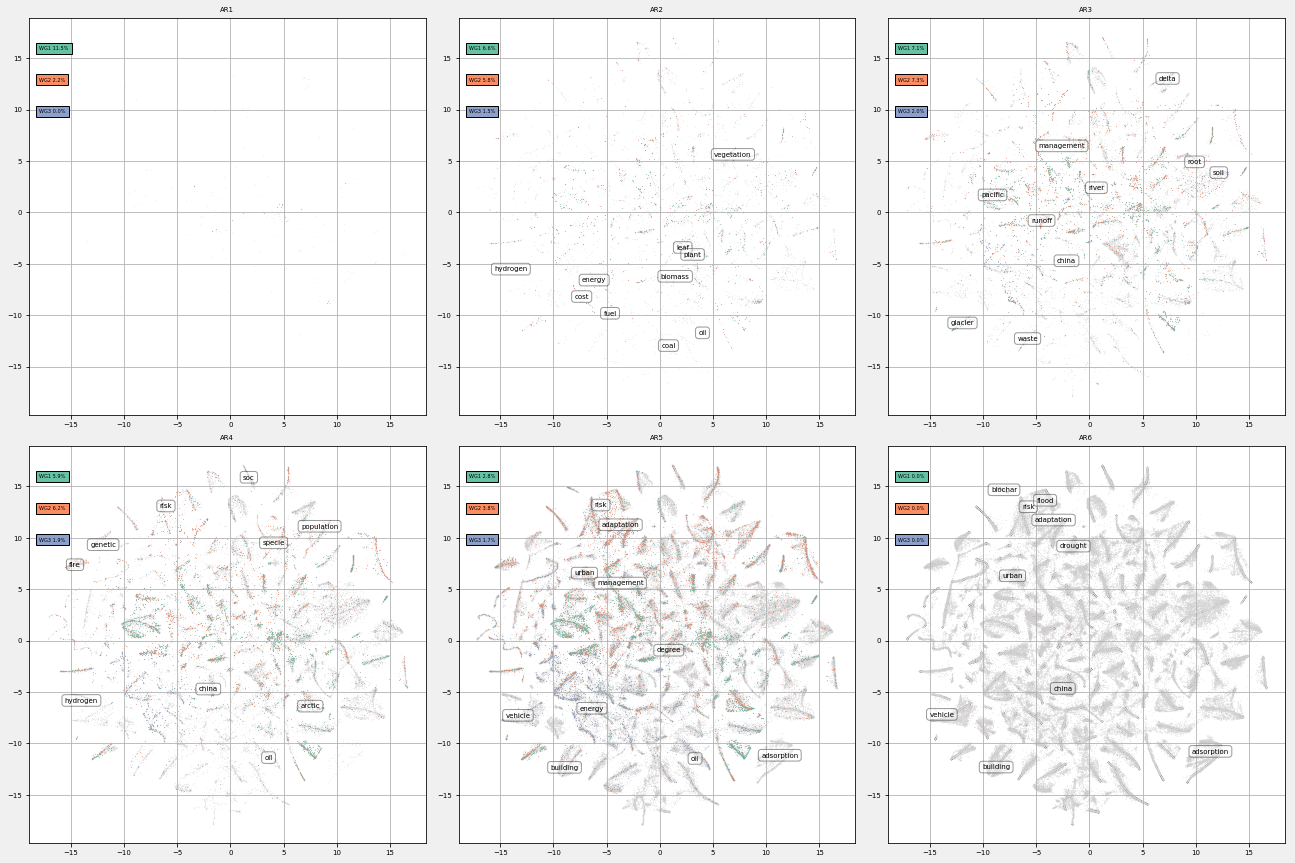

In [25]:

import importlib
importlib.reload(tmv_app.utils.plotting)


fig = plt.figure(figsize=(18,12))

sc = tplots.SquareCollection()   

rects = False

cat_type = "wgs"

for i,ar in enumerate(AR.objects.filter(ar__gt=0).order_by('ar')):
    ax = fig.add_subplot(2,3,i+1)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ys = range(ar.start,ar.end+1)
    ydocs = Doc.objects.filter(id__in=r_ind,PY__in=ys).values_list('pk',flat=True)  
    
    print(len(ydocs))
    
    doc_matches = np.argwhere(np.isin(r_ind,ydocs))[:,0]
    doc_ids = r_ind[doc_matches]
    results = tsne_results[doc_matches]

    
    if cat_type == "wgs":
        colors=["#66c2a5","#fc8d62","#8da0cb"]
        no_cats = doc_ids
        cats = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
        for i,c in enumerate(cats):
            docs = Doc.objects.filter(
                query=q,PY__in=ys,ipccref__wg__wg=c['wg']
            ).values_list('id',flat=True)
            c['docs'] = list(set(docs) & set(doc_ids))
            c['color'] = colors[i]
            c['name'] = "WG{}".format(c['wg'])
            c["dis"] = np.argwhere(np.isin(doc_ids,c['docs']))
            no_cats = no_wg_ids[np.isin(no_wg_ids,c['docs'],invert=True)]
    else:
        colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']

        no_cats = doc_ids
        cats = [
            {'wc__oecd': 'Agricultural Sciences'},
            {'wc__oecd': 'Engineering and Technology'},
            {'wc__oecd': 'Humanities'},
            {'wc__oecd': 'Medical and Health Sciences'},
            {'wc__oecd': 'Natural Sciences'},
            {'wc__oecd': 'Social Sciences'},
            {'wc__oecd': None}
        ]
        for i,c in enumerate(cats):
            ds = Doc.objects.filter(query=q, PY__in=ys, wc__oecd=c['wc__oecd']).values_list('id', flat=True)
            c['docs'] = list(set(ds) & set(doc_ids))
            c['name'] = c['wc__oecd']
            c['color'] = colors[i]
            c["dis"] = np.argwhere(np.isin(doc_ids,c['docs']))
            no_cats = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]        

    
    tp = stat.periods.get(title=ar.name)
    
    if stat.method=="DT":
        ts = DynamicTopic.objects.filter(
            run_id=run_id,
            timedtopic__period=tp,
            timedtopic__share__gt=0.01
        ).order_by('-timedtopic__pgrowthn')[:10]
    else:
        ts = Topic.objects.filter(
            run_id=run_id,
            topictimeperiodscores__period=tp,
            topictimeperiodscores__share__gt=0.005
        ).order_by('-topictimeperiodscores__pgrowth')[:10]
    
    print(ts.values('title'))
    
    tmv_app.utils.plotting.plot_tsne(
        doc_ids, results, cats,
        no_cats,ax,verbose=True,
        topics=ts, min_cluster=len(ydocs)*0.001,
        eps=1.5,
        t_thresh=0.98,
        #min_cluster=200,
        words_only=True
    )
    ax.set_title(ar.name)
    
    xs = ax.get_xticks()
    ys = ax.get_yticks()
    
    
    if rects:
        for i, x1 in enumerate(xs):
            if i==len(xs)-1:
                break
            x2 = xs[i+1]
            for j, y1 in enumerate(ys):
                if j==len(ys)-1:
                    break
                y2 = ys[j+1]

                cs = tplots.CoordSquare(x1,x2,y1,y2,doc_ids,results,ar.ar)
                cs.get_points()
                sc.add(cs)
                prev = sc.get(x1=x1,x2=x2,y1=y1,y2=y2,ar=ar.ar-1)

                if prev is not None:        
                    if cs.share > prev.share:
                        col = "green"
                    elif cs.share == prev.share:
                        col = "None"
                    else:
                        col = "red"

                    if abs(cs.share-prev.share) > 0.01:
                        alpha = 0.2
                    else:
                        alpha = 0.1

                    # Create a Rectangle patch
                    rect = patches.Rectangle(
                        (x1,y1),x2-x1,y2-y1,
                        linewidth=1,edgecolor='r',
                        facecolor=col,alpha=alpha
                    )

                    # Add the patch to the Axes
                    ax.add_patch(rect)
                
            #ax.text(
            #    x2-(x2-x1)/2,y2-(y2-y1)/2,"bla",
            #    ha="center",
            #    va="center"
            #)



fig.tight_layout()

fig.patch.set_facecolor('#f0f0f0') 

fig.tight_layout()

plt.savefig(
    f'../tsne_results/plots/run_{run_id}_s_{s}_p{p}_evolution.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)
plt.show()

23902
<QuerySet [{'title': '{scale, spatial, variability}'}, {'title': '{coal, combustion, technology}'}, {'title': '{waste, landfill, treatment}'}, {'title': '{risk, disaster, vulnerability}'}, {'title': '{cost, price, technology}'}, {'title': '{health, disease, human}'}, {'title': '{fire, burn, wildfire}'}, {'title': '{coral, reef, bleaching}'}, {'title': '{power, generation, electricity}'}, {'title': '{vegetation, ndvi, index}'}]>
calculating points took 0.176s.
33699
<QuerySet [{'title': '{soc, stock, soil}'}, {'title': '{china, province, chinese}'}, {'title': '{risk, disaster, vulnerability}'}, {'title': '{population, size, habitat}'}, {'title': '{hydrogen, catalyst, cell}'}, {'title': '{oil, biodiesel, palm}'}, {'title': '{coral, reef, bleaching}'}, {'title': '{fire, burn, wildfire}'}, {'title': '{genetic, diversity, gene}'}, {'title': '{flood, flooding, damage}'}]>
calculating points took 0.189s.
120669
<QuerySet [{'title': '{urban, city, urbanization}'}, {'title': '{adaptation,

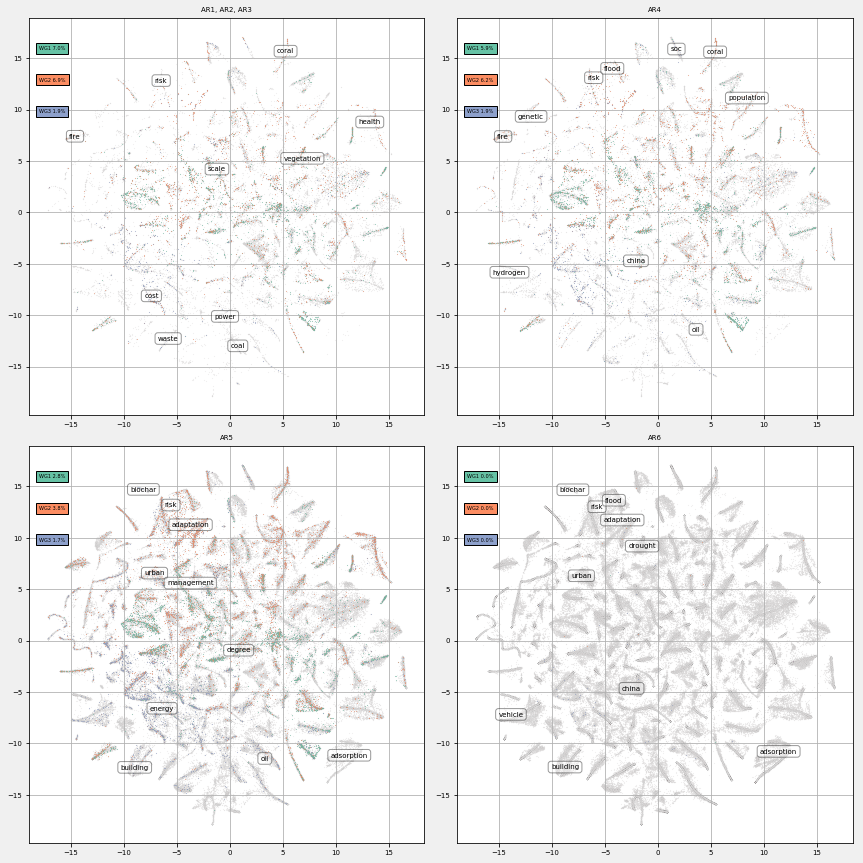

In [28]:

import importlib
importlib.reload(tmv_app.utils.plotting)


fig = plt.figure(figsize=(12,12))

sc = tplots.SquareCollection()   

rects = False

cat_type = "wgs"

ar_lists = [[1,2,3],[4],[5],[6]]

for i,ar_list in enumerate(ar_lists):
    ars = AR.objects.filter(ar__in=ar_list).order_by('ar')
    ax = fig.add_subplot(2,2,i+1)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ys = range(ars.first().start,ars.last().end+1)
    ydocs = Doc.objects.filter(id__in=r_ind,PY__in=ys).values_list('pk',flat=True)  
    
    print(len(ydocs))
    
    doc_matches = np.argwhere(np.isin(r_ind,ydocs))[:,0]
    doc_ids = r_ind[doc_matches]
    results = tsne_results[doc_matches]

    
    if cat_type == "wgs":
        colors=["#66c2a5","#fc8d62","#8da0cb"]
        no_cats = doc_ids
        cats = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
        for i,c in enumerate(cats):
            docs = Doc.objects.filter(
                query=q,PY__in=ys,ipccref__wg__wg=c['wg']
            ).values_list('id',flat=True)
            c['docs'] = list(set(docs) & set(doc_ids))
            c['color'] = colors[i]
            c['name'] = "WG{}".format(c['wg'])
            c["dis"] = np.argwhere(np.isin(doc_ids,c['docs']))
            no_cats = no_wg_ids[np.isin(no_wg_ids,c['docs'],invert=True)]
    else:
        colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']

        no_cats = doc_ids
        cats = [
            {'wc__oecd': 'Agricultural Sciences'},
            {'wc__oecd': 'Engineering and Technology'},
            {'wc__oecd': 'Humanities'},
            {'wc__oecd': 'Medical and Health Sciences'},
            {'wc__oecd': 'Natural Sciences'},
            {'wc__oecd': 'Social Sciences'},
            {'wc__oecd': None}
        ]
        for i,c in enumerate(cats):
            ds = Doc.objects.filter(query=q, PY__in=ys, wc__oecd=c['wc__oecd']).values_list('id', flat=True)
            c['docs'] = list(set(ds) & set(doc_ids))
            c['name'] = c['wc__oecd']
            c['color'] = colors[i]
            c["dis"] = np.argwhere(np.isin(doc_ids,c['docs']))
            no_cats = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]        

    
    tps = stat.periods.filter(title__in=ars.values('name'))
    
    if stat.method=="DT":
        ts = DynamicTopic.objects.filter(
            run_id=run_id,
            timedtopic__period__in=tps,
            timedtopic__share__gt=0.005
        ).order_by('-timedtopic__pgrowthn')[:10]
    else:
        ts = Topic.objects.filter(
            run_id=run_id,
            topictimeperiodscores__period__in=tps,
            topictimeperiodscores__share__gt=0.001
        ).order_by('-topictimeperiodscores__pgrowth')[:10]
    
    print(ts.values('title'))
    
    tmv_app.utils.plotting.plot_tsne(
        doc_ids, results, cats,
        no_cats,ax,verbose=True,
        topics=ts, min_cluster=len(ydocs)*0.001,
        eps=1.5,
        t_thresh=0.98,
        #min_cluster=200,
        words_only=True
    )
    ax.set_title(', '.join(ars.values_list('name',flat=True)))
    
    xs = ax.get_xticks()
    ys = ax.get_yticks()
    
    
    if rects:
        for i, x1 in enumerate(xs):
            if i==len(xs)-1:
                break
            x2 = xs[i+1]
            for j, y1 in enumerate(ys):
                if j==len(ys)-1:
                    break
                y2 = ys[j+1]

                cs = tplots.CoordSquare(x1,x2,y1,y2,doc_ids,results,ar.ar)
                cs.get_points()
                sc.add(cs)
                prev = sc.get(x1=x1,x2=x2,y1=y1,y2=y2,ar=ar.ar-1)

                if prev is not None:        
                    if cs.share > prev.share:
                        col = "green"
                    elif cs.share == prev.share:
                        col = "None"
                    else:
                        col = "red"

                    if abs(cs.share-prev.share) > 0.01:
                        alpha = 0.2
                    else:
                        alpha = 0.1

                    # Create a Rectangle patch
                    rect = patches.Rectangle(
                        (x1,y1),x2-x1,y2-y1,
                        linewidth=1,edgecolor='r',
                        facecolor=col,alpha=alpha
                    )

                    # Add the patch to the Axes
                    ax.add_patch(rect)
                
            #ax.text(
            #    x2-(x2-x1)/2,y2-(y2-y1)/2,"bla",
            #    ha="center",
            #    va="center"
            #)



fig.tight_layout()

fig.patch.set_facecolor('#f0f0f0') 

fig.tight_layout()

plt.savefig(
    f'../tsne_results/plots/run_{run_id}_s_{s}_p{p}_evolution_4.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)
plt.show()

## Clusters


In [139]:
tp

ts = Topic.objects.filter(
    run_id=run_id,
    topictimeperiodscores__period=tp,
    topictimeperiodscores__share__gt=0.005
).order_by('-topictimeperiodscores__pgrowth')[:10]

ts.values('title','topictimeperiodscores__pgrowth')

<QuerySet [{'title': '{soc, stock, soil}', 'topictimeperiodscores__pgrowth': 3.10215865815997}, {'title': '{china, province, chinese}', 'topictimeperiodscores__pgrowth': 2.28250980426581}, {'title': '{risk, disaster, vulnerability}', 'topictimeperiodscores__pgrowth': 2.01744899266854}, {'title': '{population, size, habitat}', 'topictimeperiodscores__pgrowth': 1.97271829786245}, {'title': '{hydrogen, catalyst, cell}', 'topictimeperiodscores__pgrowth': 1.72195794623199}, {'title': '{oil, biodiesel, palm}', 'topictimeperiodscores__pgrowth': 1.71504197036124}, {'title': '{fire, burn, wildfire}', 'topictimeperiodscores__pgrowth': 1.67292171799887}, {'title': '{genetic, diversity, gene}', 'topictimeperiodscores__pgrowth': 1.6486074464015}, {'title': '{specie, distribution, habitat}', 'topictimeperiodscores__pgrowth': 1.59492195663257}, {'title': '{arctic, warm, tundra}', 'topictimeperiodscores__pgrowth': 1.57658895125537}]>

<TimePeriod: AR4>

In [ ]:
import importlib
importlib.reload(tmv_app.utils.plotting)

highlight_doc = np.argwhere(r_ind==69164)[0]

tmv_app.utils.plotting.plot_tsne(r_ind,tsne_results,wgs,no_wg_ids,verbose=True, hdoc=highlight_doc)

In [ ]:
import networkx as nx
import pickle
import random
import scipy
from scipy.sparse import tril

sample = 2

Cmat = scipy.sparse.load_npz(f'../network/bibCouple_q_{qid}_{sample}.npz')

Cmat.data *= Cmat.data>=3
Cmat.eliminate_zeros()

Cmat

In [ ]:
ltri = tril(Cmat,k=-1)
G = nx.from_scipy_sparse_matrix(ltri)

In [ ]:
#G = nx.read_gpickle("/tmp/bibCouple_q_3769.pickle")
#G = nx.read_graph6(f"/tmp/bibCouple_q_{qid}_{sample}.graph6")
with open(f"../network/docnet_dict_q_{qid}_{sample}.pickle", "rb") as f:
    m_dict = pickle.load(f)
with open(f"../network/docnet_revdict_q_{qid}_{sample}.pickle", "rb") as f:
    rev_m_dict = pickle.load(f)

G.size()

In [ ]:
import importlib
importlib.reload(tmv_app.utils.plotting)

impacts = 11110
research = 11046
tech_ccs = 11026
biochar = 11020
aerosols = 11059

biochar = 11725

top = DynamicTopic.objects.get(pk=biochar)

top = DynamicTopic.objects.filter(run_id=run_id).first()
tdocs = Doc.objects.filter(
    docdynamictopic__topic=top,
    docdynamictopic__score__gt=0.03
).order_by('-docdynamictopic__score').values_list('id',flat=True)

highlight_docs = np.argwhere(np.isin(r_ind,tdocs))

tmv_app.utils.plotting.plot_tsne(
    r_ind,tsne_results,wgs,
    no_wg_ids,verbose=True, hdoc=highlight_docs
)

plt.show()

In [ ]:
import itertools

def get_topic_distance_path(top,tdocs):

    distances = []
    paths = []

    dsample_size = 100
    if len(tdocs) < dsample_size:
        dsample = tdocs
    else:
        dsample = random.sample(list(tdocs),dsample_size)

    for x_did,y_did in itertools.product(dsample, repeat=2):
        if x_did != y_did:
            x_ind = np.argwhere(np.isin(r_ind,x_did))[:,0][0]
            y_ind = np.argwhere(np.isin(r_ind,y_did))[:,0][0]
            x_tsne = tsne_results[x_ind]
            y_tsne = tsne_results[y_ind]
            try:
                x = m_dict[x_did]
                y = m_dict[y_did]
                try:
                    path = len(nx.shortest_path(G,x,y))
                except:
                    continue
                    path = 10
                    #continue
            except:
                continue
                path = 10
            paths.append(path)
            distance = square_distance(x_tsne,y_tsne)
            distances.append(distance)
    return distances, paths
            
def plot_distance_path(distances, paths):

    fig, axs = plt.subplots(2)
    axs[0].scatter([path +random.random()*0.4-0.2 for path in paths], [x - 1 for x in distances], s = 8, c = "grey")
    tdf = pd.DataFrame.from_dict({"distance": distances,"path":paths})
    x = []

    for name, group in tdf.groupby('path'):
        x.append(list(group['distance']))
    axs[1].boxplot(x)
    ax2 = axs[1].twinx()
    ax2.plot([i+1 for i in range(len(x))],[len(i) for i in x])    


distances, paths = get_topic_distance_path(top,tdocs)

plot_distance_path(distances, paths)


In [ ]:
def entropy(tdocs,var):
    sums = tdocs.values(var).annotate(
        pzc = Count('pk')
    )
    H = 0
    for s in sums:
        H+=s['pzc']*np.log(s['pzc'])

    return H, sums
H, sums = entropy(tdocs,"wc__oecd")
sums.order_by('-pzc')

In [ ]:
alltops = True
do_distances = False
topic_dicts = []

if alltops:
    try: 
        os.mkdir(f'../tsne_results/plots/topics/{run_id}')
        os.mkdir(f'../tsne_results/plots/topics/{run_id}/{p}')
    except:
        pass
    for top in DynamicTopic.objects.filter(run_id=run_id):
        tdocs = Doc.objects.filter(
            docdynamictopic__topic=top,
            docdynamictopic__score__gt=0.05
        ).order_by('-docdynamictopic__score').values_list('id',flat=True)

        highlight_docs = np.argwhere(np.isin(r_ind,tdocs))

        tmv_app.utils.plotting.plot_tsne(
            r_ind,tsne_results,wgs,
            no_wg_ids,verbose=True, hdoc=highlight_docs
        )       
        
        if not do_distances:
            plt.title(f'{top.title}')
            plt.savefig(f'../tsne_results/plots/topics/{run_id}/{p}/{top.title}.png')
            plt.clf()
            plt.close('all')
        else:
            distances, paths = get_topic_distance_path(top, tdocs)

            plt.title(f'{top.title} average distance: {np.mean(distances)}\nav. shortest path: {np.mean(paths)}')                
            plt.savefig(f'../tsne_results/plots/topics/{run_id}/{p}/{top.title}.png')
            plt.clf()
            plt.close('all')
            
            plot_distance_path(distances, paths)
            plt.savefig(f'../tsne_results/plots/topics/{run_id}/{p}/{top.title}_distances.png')

            plt.clf()
            plt.close('all')
            
            H, sums = entropy(tdocs, 'wosarticle__so')
            
            print(top.title)
            print(pd.DataFrame.from_dict(list(sums.order_by('-pzc'))).head())
                     
            oecd_H, sums = entropy(tdocs, 'wc__oecd')  
            wc_H, sums = entropy(tdocs, 'wc__text')  
            kw_H, sums = entropy(tdocs, 'kw__text')
            
            print(top.title)
            print(pd.DataFrame.from_dict(list(sums.order_by('-pzc'))).head())
            
            wg_H, sums = entropy(tdocs, 'ipccref__wg__wg')
            

            
            topic_dict = {
                "topic_id": top.id,
                "distance": np.mean(distances),
                "path": np.mean(paths),
                "journal_entropy": H,
                "wc_entropy": wc_H,
                "oecd_entroy": oecd_H,
                "wg_entropy": wg_H,
                "kw_entroy": kw_H
            }
            

            topic_dicts.append(topic_dict)
            
df = pd.DataFrame.from_dict(topic_dicts)

In [ ]:
def label_topic(row):
    t = DynamicTopic.objects.get(pk=row['topic_id'])
    return t.title
df['topic__title'] = df.apply(lambda row: label_topic(row), axis=1)
for c in ["journal_entropy","kw_entroy","oecd_entroy","wc_entropy","wg_entropy"]:
    df[c] = -1*df[c]
df

We propose to measure the breadth of a conference by using what we call topic entropy: the conditional entropy of this conference topic distribution. Entropy measures the average amount of information expressed by each assignment to a random variable. If a conference has higher topic entropy, then it more evenly divides its probability mass across the generated topics. If it has lower, it has a far more narrow focus on just a couple of topics. We therefore measured topic entropy:

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
df.to_csv(f"../tables/topic_info_{run_id}_{p}.csv")
pdf = df.sort_values('wg_entropy',ascending=False).reset_index(drop=True)
pdf[['distance',"journal_entropy","kw_entroy","oecd_entroy","path"]].plot(ax=ax)
ax.set_xticks(pdf.index)
ax.set_xticklabels(pdf['topic__title'],rotation=45,ha="right")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
pdf[["oecd_entroy","wg_entropy"]].plot(ax=ax)
ax.set_xticks(pdf.index)
ax.set_xticklabels(pdf['topic__title'],rotation=45,ha="right")
plt.show()

In [ ]:
xlim = axs[1].get_xlim()
ylim = axs[1].get_ylim()

In [ ]:
for i,ar in enumerate(AR.objects.filter(ar__gt=0).order_by('ar')):  
    tp = stat.periods.get(title=ar.name)
    ts = DynamicTopic.objects.filter(
        run_id=run_id,
        timedtopic__period=tp,
        timedtopic__share__gt=0.01
    ).order_by('-timedtopic__pgrowth')[:8]
    print()
    print(ts.values('title'))

In [ ]:
import importlib
importlib.reload(tmv_app.utils.plotting)

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(2,3,1)
do_wgs = True

ar = AR.objects.get(ar=4)
ys = range(ar.start,ar.end+1)
ydocs = Doc.objects.filter(id__in=r_ind,PY__in=ys).values_list('pk',flat=True)  

print(len(ydocs))

doc_matches = np.argwhere(np.isin(r_ind,ydocs))[:,0]
doc_ids = r_ind[doc_matches]
results = tsne_results[doc_matches]

if do_wgs:
    colors=["#66c2a5","#fc8d62","#8da0cb"]
    no_cats = doc_ids
    cats = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
    for i,c in enumerate(cats):
        docs = Doc.objects.filter(
            query=q,PY__in=ys,ipccref__wg__wg=c['wg']
        ).values_list('id',flat=True)
        c['docs'] = list(set(docs) & set(doc_ids))
        c['color'] = colors[i]
        c['name'] = "WG{}".format(c['wg'])
        c["dis"] = np.argwhere(np.isin(doc_ids,c['docs']))
        no_cats = no_wg_ids[np.isin(no_wg_ids,c['docs'],invert=True)]
else:
    colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']

    no_cats = doc_ids
    cats = [
        {'wc__oecd': 'Agricultural Sciences'},
        {'wc__oecd': 'Engineering and Technology'},
        {'wc__oecd': 'Humanities'},
        {'wc__oecd': 'Medical and Health Sciences'},
        {'wc__oecd': 'Natural Sciences'},
        {'wc__oecd': 'Social Sciences'},
        {'wc__oecd': None}
    ]
    for i,c in enumerate(cats):
        ds = Doc.objects.filter(query=q, PY__in=ys, wc__oecd=c['wc__oecd']).values_list('id', flat=True)
        c['docs'] = list(set(ds) & set(doc_ids))
        c['name'] = c['wc__oecd']
        c['color'] = colors[i]
        c["dis"] = np.argwhere(np.isin(doc_ids,c['docs']))
        no_cats = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]



tp = stat.periods.get(title=ar.name)

ts = DynamicTopic.objects.filter(
    run_id=run_id,
    timedtopic__period=tp,
    timedtopic__share__gt=0.01
).order_by('-timedtopic__pgrowthn')[:10]

print(ts.values('title'))

tmv_app.utils.plotting.plot_tsne(
    doc_ids, results, cats,
    no_cats, ax, verbose=True,
    topics=ts, min_cluster=len(ydocs)*0.001
)

plt.show()

In [ ]:
def square_distance(x,y): return sum([(xi-yi)**2 for xi, yi in zip(x,y)]) 

def get_doc():
    for i in range(25):
        x = random.randint(0,len(m_dict))
        x_did = rev_m_dict[x]
        try:
            x_ind = np.argwhere(np.isin(r_ind,x_did))[:,0][0]
            x_doc = Doc.objects.get(pk=x_did)
            tsne = tsne_results[x_ind]
            break
        except:
            pass
    return x, x_did, x_ind, x_doc, tsne

X = []
Y = []

for i in range(1000):  
    x, x_ind, x_did, x_doc, x_tsne = get_doc()       
    y, y_ind, y_did, y_doc, y_tsne = get_doc()

    #print(x_doc.title)
    #print(y_doc.title)

    distance = square_distance(x_tsne,y_tsne)

    try:
        path = len(nx.shortest_path(G,x,y))
        X.append(path)
        Y.append(distance)
    except:
        path = 10
        continue
        

    plt.scatter(path + random.random()*0.1-0.05, distance, s = 8, c = "grey")



plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)))


In [ ]:
fig = plt.figure(figsize=(7.2,5))
fig = plt.figure(figsize=(14,10))
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']
for i in range(6):  
    x, x_ind, x_did, x_doc, x_tsne = get_doc()       
    y, y_ind, y_did, y_doc, y_tsne = get_doc()

    #print(x_doc.title)
    #print(y_doc.title)

    distance = square_distance(x_tsne,y_tsne)

    try:
        path = nx.shortest_path(G,x,y)
    except:
        continue
        
    plt.scatter(x_tsne[0],x_tsne[1], c=colors[i],edgecolor="black")
    plt.text(x_tsne[0],x_tsne[1],x_doc.title)
    
    plt.scatter(y_tsne[0],y_tsne[1], c=colors[i],edgecolor="black")
    plt.text(y_tsne[0],y_tsne[1],y_doc.title)
    
    for j in path:
        j_did = rev_m_dict[j]
        j_ind = np.argwhere(np.isin(r_ind,j_did))[:,0][0]
        j_doc = Doc.objects.get(pk=j_did)
        tsne = tsne_results[x_ind]
        plt.scatter(tsne[0],tsne[1], c=colors[i],edgecolor="black")
        #plt.text(y_tsne[0],y_tsne[1],y_doc.title)

In [ ]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']
for i in range(8):  
    x, x_ind, x_did, x_doc, x_tsne = get_doc()       
    y, y_ind, y_did, y_doc, y_tsne = get_doc()

    #print(x_doc.title)
    #print(y_doc.title)

    distance = square_distance(x_tsne,y_tsne)

    try:
        path = nx.shortest_path(G,x,y)
    except:
        continue
        
    print("\n############")
    print(f"T-sne distance {distance}")
    print(f"{x_doc.title}")
    
    for j in path[1:-1]:
        j_did = rev_m_dict[j]
        try:
            j_ind = np.argwhere(np.isin(r_ind,j_did))[:,0][0]
        except:
            pass
        j_doc = Doc.objects.get(pk=j_did)
        print(f" - via - {j_doc.title}")
        tsne = tsne_results[x_ind]
        #plt.scatter(tsne[0],tsne[1], c=colors[i])
        #plt.text(y_tsne[0],y_tsne[1],y_doc.title)
    print(y_doc.title)

## Report topic composition of each square..... give in SM

##  furthest and closest points



def square_distance(x,y): return sum([(xi-yi)**2 for xi, yi in zip(x,y)])    

square_distance(tsne_results[0],tsne_results[1])
ma = 0
mi = 100
for i in range(len(tsne_results)):
    for j in range(len(tsne_results)):
        if i != j:
            d = square_distance(tsne_results[i],tsne_results[j])
            if d < mi:
                mi = d
                p1mi = i
                p2mi = j
            if d > ma:
                ma = d
                p1ma = i
                p1mi = j
        

from scipy.spatial import cKDTree
from scipy.spatial.distance import pdist, squareform
import timeit

Y = pdist(tsne_results[:10000])

Y.shape

m = squareform(Y)

m.shape

outside_points = tsne_results[(abs(tsne_results[:,0])>10) & (abs(tsne_results[:,1])>10)]

Y = pdist(outside_points)

m = squareform(Y)

m[2167,2168]